# Section 5.2 — Bayesian inference computations

This notebook contains the code examples from [Section 5.2 Bayesian inference computations]() from the **No Bullshit Guide to Statistics**.

See also:

- [Chp_04.ipynb](./explorations/SR2024/week02/Chp_04.ipynb)
- [Chp_05.ipynb](./explorations/SR2024/week02/Chp_05.ipynb)
- [homework_week02_ivan_savov.ipynb](./explorations/SR2024/week02/homework_week02_ivan_savov.ipynb)

#### Notebook setup

In [1]:
# load Python modules
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Figures setup
plt.clf()  # needed otherwise `sns.set_theme` doesn"t work
from plot_helpers import RCPARAMS
RCPARAMS.update({"figure.figsize": (5, 3)})   # good for screen
# RCPARAMS.update({"figure.figsize": (5, 1.6)})  # good for print
sns.set_theme(
    context="paper",
    style="whitegrid",
    palette="colorblind",
    rc=RCPARAMS,
)

# High-resolution please
%config InlineBackend.figure_format = "retina"

# Where to store figures
DESTDIR = "figures/bayes/computations"

<Figure size 640x480 with 0 Axes>

In [3]:
# set random seed for repeatability
np.random.seed(42)
#######################################################

## Definitions

TODO

## Posterior inference using MCMC estimation

## Components of a Bayesian model

## Example 1: estimating the bias of a coin

In [4]:
# Sample of coin tosses observations (1=heads 0=tails)
# We assume they come from a Bernoulli distribution
ctosses = [1,1,0,0,1,0,1,1,1,1,1,0,1,1,0,0,0,1,1,1,
           1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,0,0,1,0,
           0,1,0,1,0,1,0,1,1,0]
sum(ctosses), len(ctosses), sum(ctosses)/len(ctosses)

(34, 50, 0.68)

In [5]:
df1 = pd.DataFrame({"heads":ctosses})
# df1.head()

In [6]:
# ALT. load the `ctosses` data frame from the exercises/ folder
df1 = pd.read_csv("../datasets/exercises/ctosses.csv")
# df1.head()

In [7]:
df1["heads"].mean()

0.68

The model is

$$
    C \sim \textrm{Bernoulli}(p),
    \qquad
    p \sim \mathcal{U}(0,1).
$$

In [8]:
# BONUS DEMO: simulate a random sample from the data model (for a fixed `true_p`)
# np.random.seed(46)

# params
n = len(ctosses)
true_p = 0.7

# gen a random dataframe DF1 like df1
from scipy.stats import bernoulli
ctosses = bernoulli(p=true_p).rvs(n)
DF1 = pd.DataFrame({"heads": ctosses})
DF1["heads"].values, DF1["heads"].mean()

(array([1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0,
        1, 1, 1, 1, 1, 1]),
 0.78)

In [9]:
# BONUS DEMO 2: simulate a random sample from the full Bayesian model
# np.random.seed(47)
n = len(ctosses)

# gen parameters p independently for each observation
from scipy.stats import uniform
true_ps = uniform(0,1).rvs(n)

# gen a random data sample of size n
from scipy.stats import bernoulli
ctosses = bernoulli(p=true_ps).rvs(n)
DF1 = pd.DataFrame({"ctoss": ctosses})
DF1["ctoss"].values, DF1["ctoss"].mean()

(array([1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1,
        0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
        1, 0, 0, 0, 0, 0]),
 0.46)

In [10]:
import bambi as bmb

formula1 = "heads ~ 1"

priors1 = {
    "Intercept": bmb.Prior("Uniform", lower=0, upper=1),
    # "Intercept": bmb.Prior("Beta", alpha=1, beta=1),
}

#######################################################
mod1 = bmb.Model(formula1,
                 priors=priors1,
                 family="bernoulli",
                 link="identity",
                 data=df1)
mod1.set_alias({"Intercept":"P"})
mod1

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


       Formula: heads ~ 1
        Family: bernoulli
          Link: p = identity
  Observations: 50
        Priors: 
    target = p
        Common-level effects
            Intercept ~ Uniform(lower: 0.0, upper: 1.0)

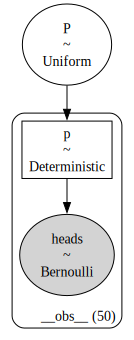

In [11]:
mod1.build()
mod1.graph()

In [12]:
idata1 = mod1.fit(draws=2000)

Modeling the probability that heads==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [P]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.


In [13]:
# idata1

In [14]:
import arviz as az
post1 = az.extract(idata1, group="posterior", var_names="P").values
post1

array([0.70451878, 0.70098137, 0.73572236, ..., 0.76527517, 0.69935091,
       0.68955665])

In [15]:
# ALT. manually extract
post1 = idata1["posterior"]["P"].stack(sample=("chain", "draw")).values
post1

array([0.70451878, 0.70098137, 0.73572236, ..., 0.76527517, 0.69935091,
       0.68955665])

### Visualize the posterior

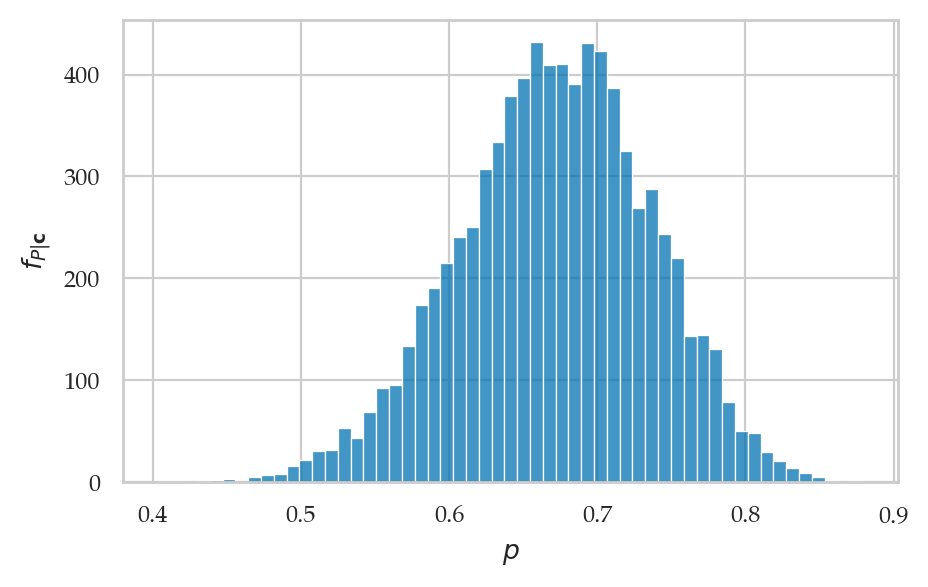

In [16]:
# ax = sns.kdeplot(x=post1);
ax = sns.histplot(x=post1);
ax.set_xlabel("$p$")
ax.set_ylabel("$f_{P|\\mathbf{c}}$");

### Summarize the posterior

#### Posterior mean

In [17]:
postmu1 = np.mean(post1)
postmu1

0.6713548542326948

#### Posterior standard deviation

In [18]:
postvar1 = np.sum((post1-postmu1)**2) / len(post1)
poststd1 = np.sqrt(postvar1)
poststd1

0.06464915775521585

#### Posterior median

In [19]:
np.median(post1)

0.6729673384368701

#### Posterior quartiles

In [20]:
np.quantile(post1, [0.25, 0.5, 0.75])

array([0.62907061, 0.67296734, 0.71567636])

#### Posterior percentiles

In [21]:
np.percentile(post1, [3, 97])

array([0.54465505, 0.78563566])

#### Posterior mode

In [22]:
# 1. Fit a Gaussian KDE curve approx. to the posterior samples `post1`
from scipy.stats import gaussian_kde
post1_kde = gaussian_kde(post1)

# 2. Find the max of the KDE curve
ps = np.linspace(0, 1, 10001)
densities1 = post1_kde(ps)
ps[np.argmax(densities1)]

0.6689

### Credible interval

In [23]:
from ministats.hpdi import hpdi_from_samples
hpdi_from_samples(post1, hdi_prob=0.9)

[0.5676973864719955, 0.7787219862711429]

### Predictions

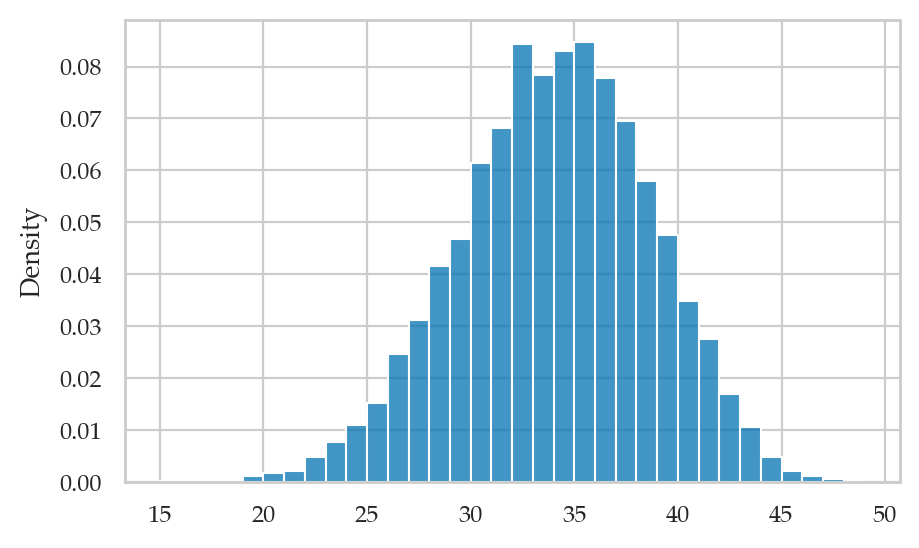

In [24]:
idata1_pred = idata1.copy()
# MAYBE: alt notation _rep instead of _pred ?
mod1.predict(idata1_pred, kind="response")
preds1 = az.extract(idata1_pred, group="posterior_predictive", var_names="heads").values
sns.histplot(x=preds1.sum(axis=0), stat="density", bins=range(15,50));

## Example 2: estimating an unknown mean

In [25]:
# Sample of IQ observations
iqs = [ 82.6, 105.5,  96.7,  84.0, 127.2,  98.8,  94.3,
       122.1,  86.8,  86.1, 107.9, 118.9, 116.5, 101.0,
        91.0, 130.0, 155.7, 120.8, 107.9, 117.1, 100.1,
       108.2,  99.8, 103.6, 108.1, 110.3, 101.8, 131.7,
       103.8, 116.4]

We assume the IQ scores come from a population with standard deviation $\sigma = 15$.

In [26]:
df2 = pd.DataFrame({"iq":iqs})
np.mean(iqs)

107.82333333333334

In [27]:
# ALT. load the `iqs.csv` data file from the exercises/ folder
df2 = pd.read_csv("../datasets/exercises/iqs.csv")
df2["iq"].mean()

107.82333333333334

The model is

$$
    X \sim \mathcal{N}(M, \sigma=15),
    \qquad
    M \sim \mathcal{N}(\mu_M=100,\sigma_M=40).
$$

In [28]:
import bambi as bmb

formula2 = "iq ~ 1"

priors2 = {
    "Intercept": bmb.Prior("Normal", mu=100, sigma=40),
    "sigma": bmb.Prior("Data", value=15),
}

mod2 = bmb.Model(formula2,
                 priors=priors2,
                 family="gaussian",
                 link="identity",
                 data=df2)

mod2.set_alias({"Intercept":"M"})
mod2

       Formula: iq ~ 1
        Family: gaussian
          Link: mu = identity
  Observations: 30
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 100.0, sigma: 40.0)
        
        Auxiliary parameters
            sigma ~ Data(value: 15.0)

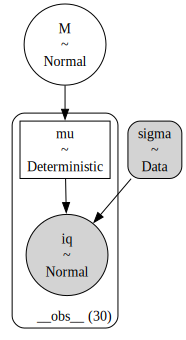

In [29]:
mod2.build()
mod2.graph()

In [30]:
# Inspect different types of variables in the model
mod2.backend.model.data_vars, \
mod2.backend.model.observed_RVs, \
mod2.backend.model.unobserved_RVs

([sigma], [iq], [M, mu])

In [31]:
idata2 = mod2.fit(draws=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [M]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.


In [32]:
import arviz as az
post2 = az.extract(idata2, group="posterior", var_names="M").values
post2

array([105.78975236, 106.05993415, 103.60179907, ..., 102.77372777,
       107.57079739, 102.11817756])

### Summarize the posterior

#### Posterior mean

In [33]:
postmu2 = np.mean(post2)
postmu2

107.82728101451683

#### Posterior standard deviation

In [34]:
postvar2 = np.sum((post2-postmu2)**2) / len(post2)
poststd2 = np.sqrt(postvar2)
poststd2

2.707519811955393

#### Posterior median

In [35]:
np.median(post2)

107.85456874244214

#### Posterior quartiles

In [36]:
np.quantile(post2, [0.25, 0.5, 0.75])

array([105.9427669 , 107.85456874, 109.68024587])

#### Posterior percentiles

In [37]:
np.percentile(post2, [3, 97])

array([102.78281672, 112.88258315])

#### Posterior mode

In [38]:
# 1. Fit a Gaussian KDE curve approx. to the posterior samples `post1`
from scipy.stats import gaussian_kde
post2_kde = gaussian_kde(post2)

# 2. Find the max of the KDE curve
mus = np.linspace(0, 200, 10001)
densities2 = post2_kde(mus)
mus[np.argmax(densities2)]

108.06

### Credible interval

In [39]:
from ministats.hpdi import hpdi_from_samples
hpdi_from_samples(post2, hdi_prob=0.9)

[103.36091671206084, 112.22329877607842]

### Predictions

In [40]:
## Can't use Bambi predict because of issue
## https://github.com/bambinos/bambi/issues/850
# idata2_pred = mod2.predict(idata2, kind="response", inplace=False)
# preds2 = az.extract(idata2_pred, group="posterior", var_names="mu").values.flatten()

In [41]:
from scipy.stats import norm

sigma = 15  # known population standard deviation

preds2 = []
np.random.seed(42)
for i in range(1000):
    mu_post = np.random.choice(post2)
    iq_pred = norm(loc=mu_post, scale=sigma).rvs(1)[0]
    preds2.append(iq_pred)

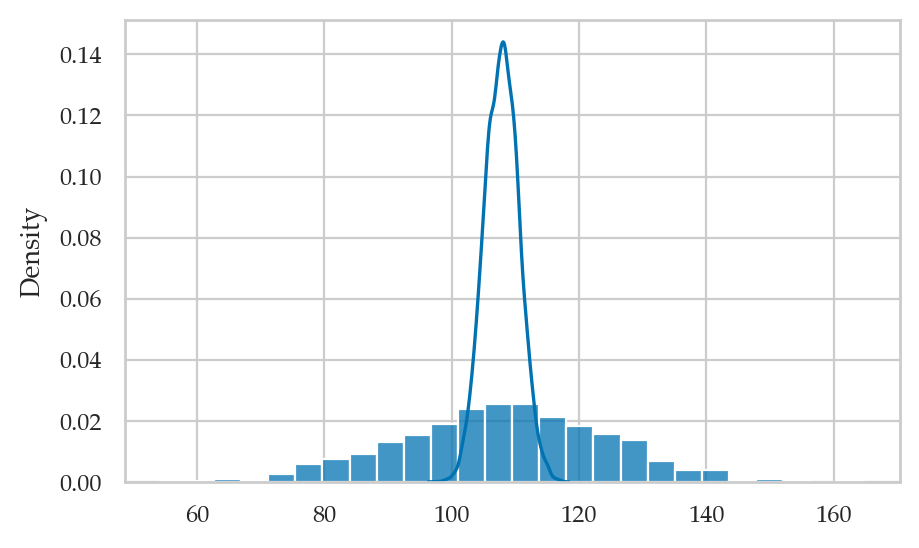

In [42]:
sns.histplot(x=preds2, stat="density")
sns.kdeplot(x=post2);

## Visualizing and interpreting posteriors

In [43]:
import arviz as az

### Example 1 continued: inferences about the biased coin

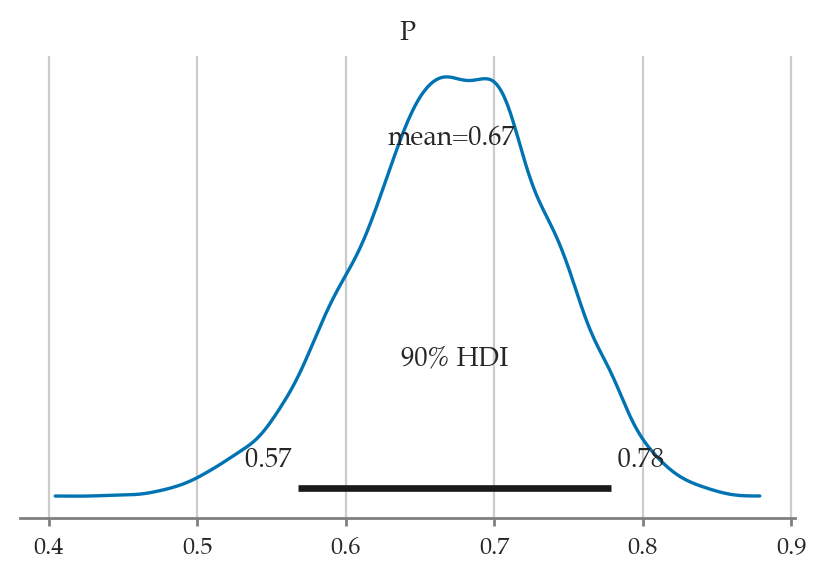

In [44]:
az.plot_posterior(idata1, hdi_prob=0.9);

Options:
- If multiple variables, you specify a list to `var_names` to select only certain variables to plot
- Set the option `point_estimate` to `"mode"` or `"median"`
- Add the option `rope` to draw region of practical equivalence,
  e.g., `rope=[97,103]`

In [45]:
az.summary(idata1, kind="stats", hdi_prob=0.9)

,mean,sd,hdi_5%,hdi_95%
P,0.671,0.065,0.568,0.779


### Example 2 continued: inferences about the population mean

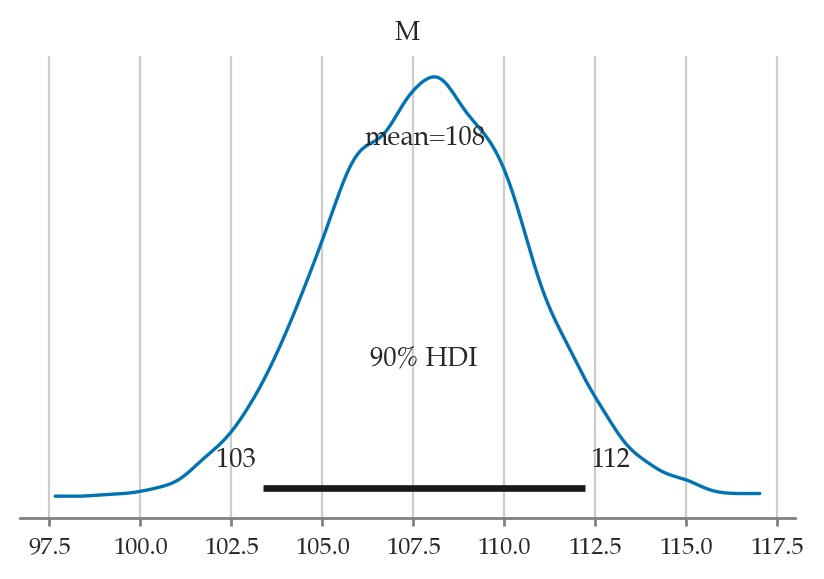

In [46]:
az.plot_posterior(idata2, hdi_prob=0.9);

In [47]:
az.summary(idata2, kind="stats", hdi_prob=0.9)

,mean,sd,hdi_5%,hdi_95%
M,107.827,2.708,103.361,112.223


## Explanations

### Choosing priors

### More info about data inference objects

In [48]:
type(idata1)

arviz.data.inference_data.InferenceData

In [49]:
idata1.groups()

['posterior', 'sample_stats', 'observed_data']

In [50]:
posterior1 = idata1["posterior"]
type(posterior1)

xarray.core.dataset.Dataset

In [51]:
posterior1.dims

FrozenMappingWarningOnValuesAccess({'chain': 4, 'draw': 2000})

In [52]:
list(posterior1.variables)

['chain', 'draw', 'P']

In [53]:
Ps = posterior1["P"]
type(Ps)

xarray.core.dataarray.DataArray

In [54]:
Ps.dims, Ps.shape

(('chain', 'draw'), (4, 2000))

### MCMC diagnostics


#### MCMC diagnostic plots

There are several Arviz plots we can use to check if the Markov Chain Monte Carlo chains were sampling from the posterior as expected, or ...

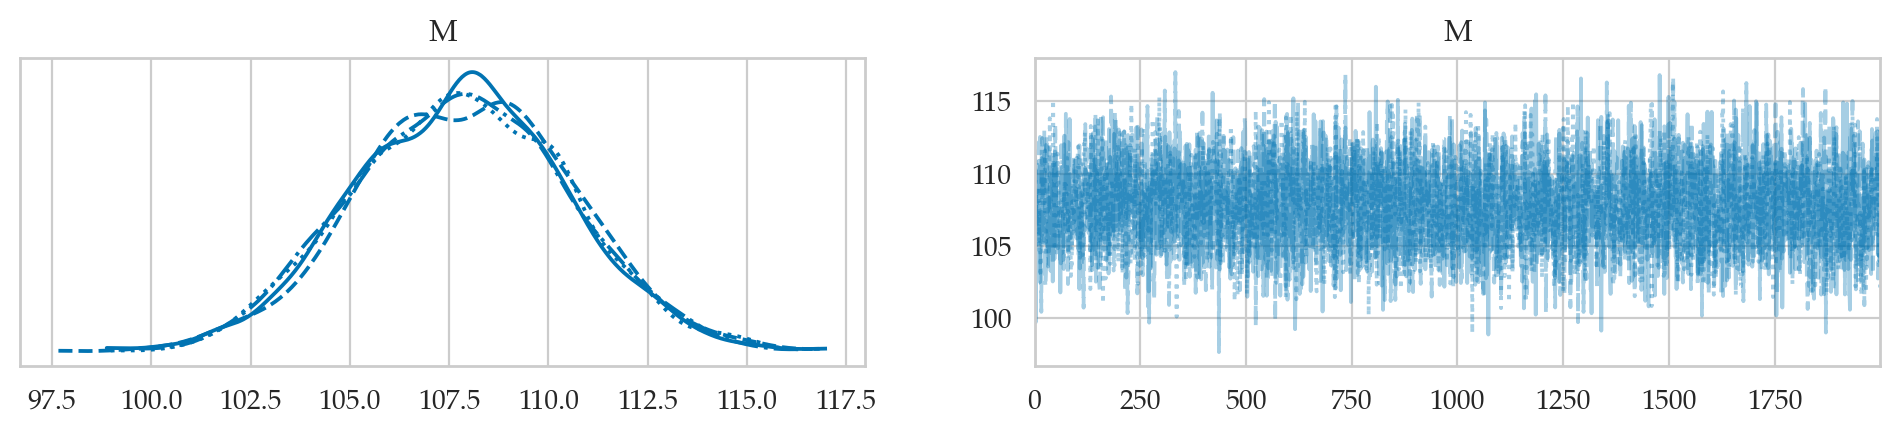

In [55]:
az.plot_trace(idata2);

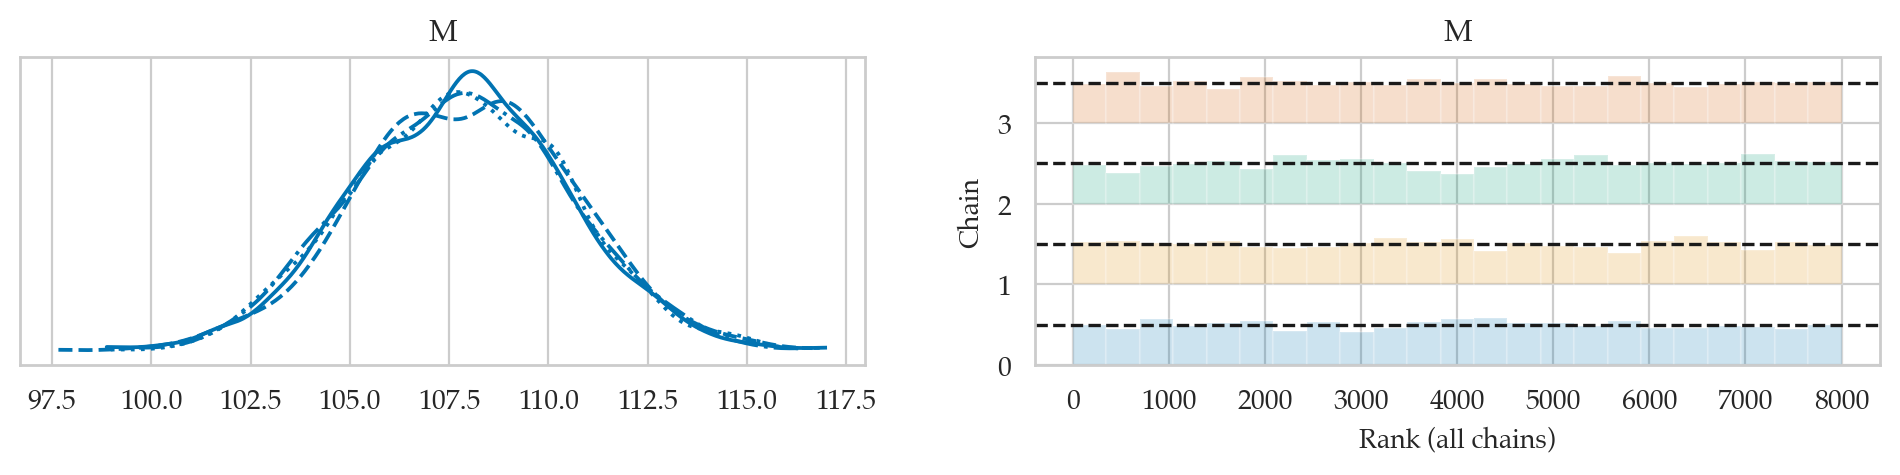

In [56]:
az.plot_trace(idata2, kind="rank_bars");

In [57]:
az.summary(idata1, kind="diagnostics")

,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
P,0.001,0.001,3157.0,4753.0,1.0


In [58]:
az.summary(idata2, kind="diagnostics")

,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
M,0.044,0.031,3829.0,5572.0,1.0


## Discussion

### Bambi default priors

In [59]:
import bambi as bmb

mod2d = bmb.Model("iq ~ 1", family="gaussian", data=df2)
mod2d.set_alias({"Intercept":"M"})
mod2d

       Formula: iq ~ 1
        Family: gaussian
          Link: mu = identity
  Observations: 30
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 107.8233, sigma: 39.5303)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 15.8121)

In [60]:
np.mean(iqs), np.std(iqs), 2.5*np.std(iqs)

(107.82333333333334, 15.812119472803834, 39.53029868200959)

Sampling: [M, sigma]


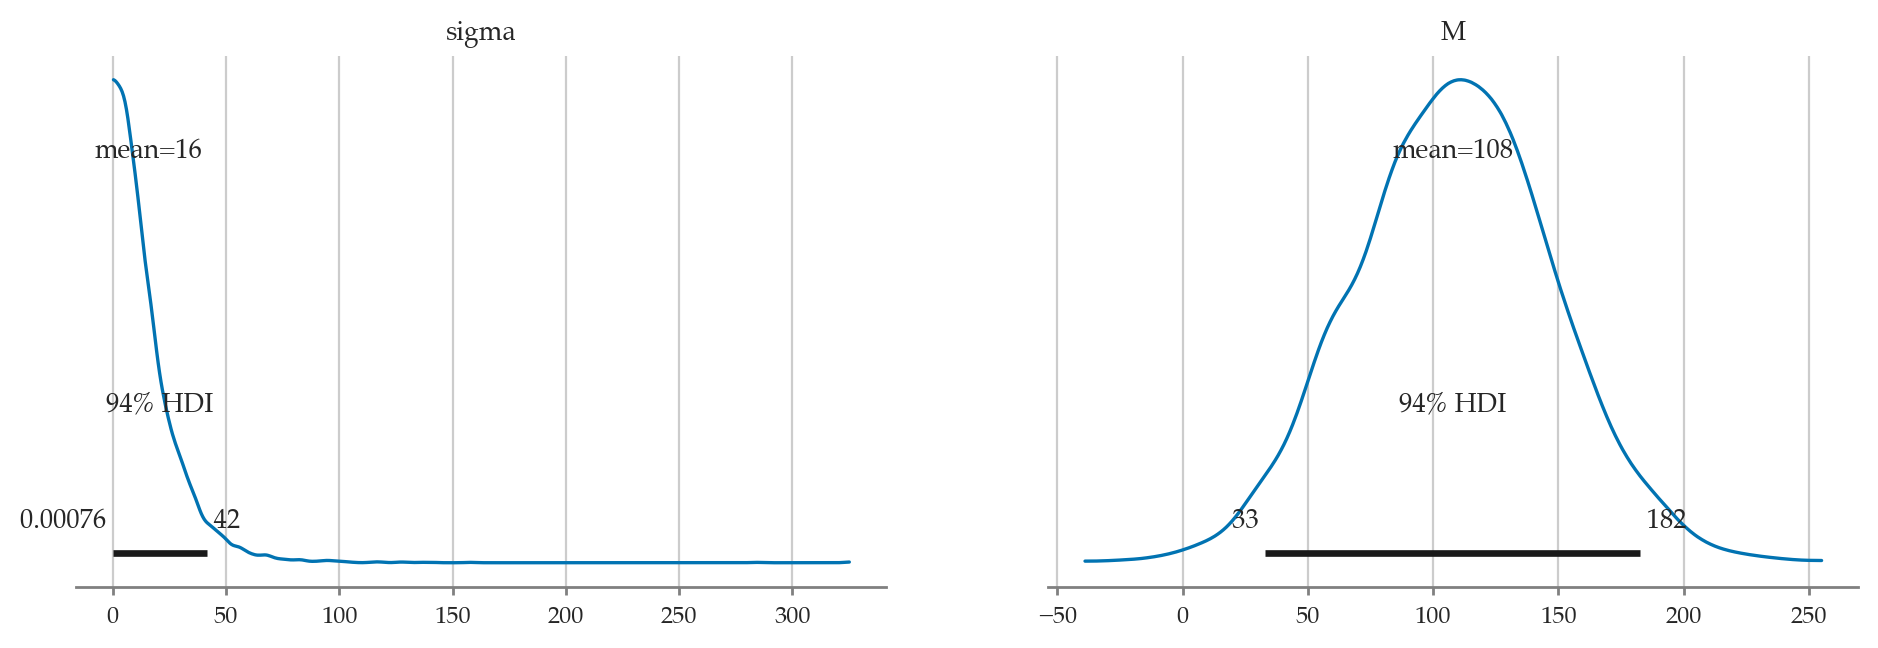

In [61]:
mod2d.build()
mod2d.plot_priors();

### Probabilistic programming languages

### The Bayesian workflow

Sampling: [P]


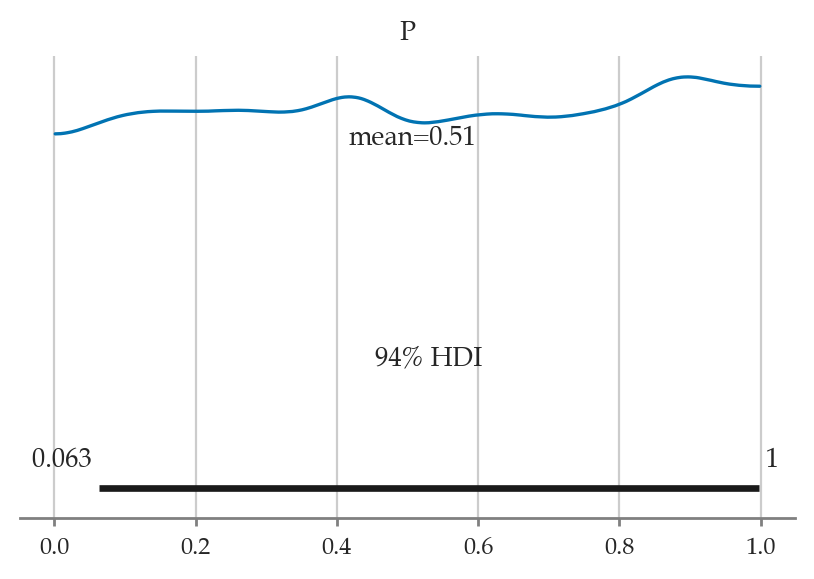

In [62]:
# BONUS: verify the prior was flat
mod1.plot_priors();

### Choice of priors

Different priors lead to different posteriors.

See `Code 1.8 and Figure 1.7` in
[chp_01.ipynb](./explorations/PyBayesianBookCode/notebooks_updated/chp_01.ipynb)

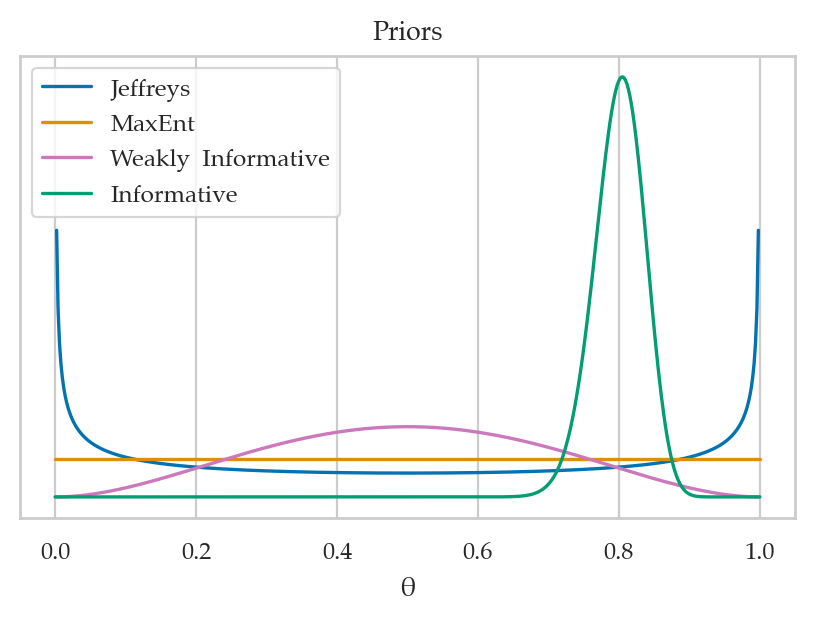

In [63]:
from scipy.stats import beta

x = np.linspace(0, 1, 500)
params = [(0.5, 0.5), (1, 1), (3,3), (100, 25)]

labels = ["Jeffreys",
          "MaxEnt",
          "Weakly  Informative",
          "Informative"]

_, ax = plt.subplots()
for (α, β), label, c in zip(params, labels, (0, 1, 4, 2)):
    pdf = beta.pdf(x, α, β)
    ax.plot(x, pdf, label=f"{label}", c=f"C{c}")
    ax.set(yticks=[], xlabel="θ", title="Priors")
    ax.legend()
# plt.savefig("img/chp01/prior_informativeness_spectrum.png")

### Bayesian workflow

See also [chp_09.ipynb](./explorations/PyBayesianBookCode/notebooks_updated/chp_09.ipynb)

## Exercises

## Links